In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [161]:
import json

import numpy as np
import pandas as pd
import quantstats as qs

import calendar as cal

from pathlib import Path

import matplotlib.pyplot as plt

from preprocess import positions_xls_to_df, positions_raw_to_clean, generate_cashflows
from model import compute_weights
from api_methods import get_login_data, download_positions, download_cashflows

from IPython.display import clear_output

In [5]:
qs.extend_pandas()

plt.style.use('ggplot')

In [90]:
ISIN_CASH = 'LU1959429272'
DERIVATIVES = ['ES0A02188001', 'ES0A02188050']

# Data

In [162]:
user_data = get_login_data()
clear_output()

In [163]:
date_start = '20191001'
date_end   = '20200327'

In [9]:
path = Path(r'positions/')

Descargamos el excel con la composición del portfolio de cada día laborable:

In [10]:
calendar = pd.date_range(start = date_start, end = date_end, freq = 'B')

In [9]:
download_positions(calendar          = calendar, 
                   path              = path, 
                   data              = user_data,
                   filename_template = 'pos_%Y%m%d')

100%|██████████| 129/129 [00:52<00:00,  2.46it/s]


## Parse the Excel files and clean output

Una vez descargados los excel con el portfolio de cada dia, los cargamos en un DataFrame:

In [11]:
positions_raw_df = positions_xls_to_df(path, isin_cash=ISIN_CASH)

amount_df, prices_df, shares_df, nav_df, returns_df = positions_raw_to_clean(positions_raw_df)

## Cashflows

### Download

In [164]:
path_account = download_cashflows(user_data, date_start, date_end, path)

### Assemble

In [40]:
cashflows_df, cashflows_external_df = generate_cashflows(path_account=path_account, isin_cash = ISIN_CASH)

cashflows_ss = cashflows_df.drop(columns=ISIN_CASH).sum(axis=1)

cashflows_total_ss  = cashflows_external_df.set_index('date')['amount'].reindex(cashflows_ss.index, fill_value = 0.0) 
cashflows_total_ss += cashflows_ss

### Prepare data to portfolio inception

In [64]:
first_date = amount_df.drop(columns=ISIN_CASH).first_valid_index()

amount_df  = amount_df. loc[first_date:]
shares_df  = shares_df. loc[first_date:]
prices_df  = prices_df. loc[first_date:]
nav_df     = nav_df.    loc[first_date:]
returns_df = returns_df.loc[first_date:]

### Compute cash returns

In [107]:
for today, yesterday in zip(cashflows_total_ss.index[1:], cashflows_total_ss.index):
    
    cash_today = amount_df.loc[today, ISIN_CASH]
    cash_yesterday = amount_df.loc[yesterday, ISIN_CASH]
    
    flows = cashflows_total_ss.loc[today]
    
    returns_df.loc[today, ISIN_CASH] = (cash_today - flows) / cash_yesterday - 1

## Compute performance

In [166]:
amount_long_df = amount_df.drop(columns=DERIVATIVES).copy()
#amount_long_df = amount_df.copy()

weights_df = amount_long_df.div(amount_long_df.sum(axis=1), axis='index').shift(1)
weights_df = weights_df.rename(columns={ISIN_CASH:'Cash'})

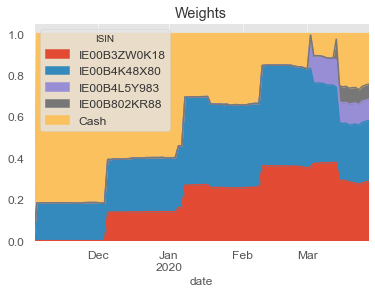

In [167]:
weights_df.plot.area(title = 'Weights')

In [ ]:
pd.DataFrame.plot.pie()

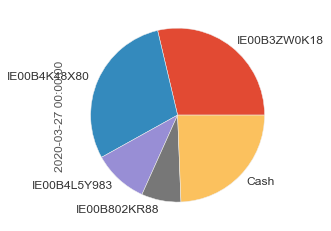

In [172]:
weights_df.tail(1).T[weights_df.index[-1]].plot.pie()

In [158]:
pf_returns_ss = (returns_df * weights_df).dropna(how = 'all').sum(axis=1)
pf_equity_ss  = pf_returns_ss.add(1).cumprod().sub(1)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2019-11-05  2019-11-05
End Period                 2020-03-27  2020-03-27
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      98.0%

Cumulative Return          -23.18%     -28.02%
CAGR%                      -49.0%      -56.79%
Sharpe                     -2.43       -1.87
Sortino                    -2.75       -2.17
Max Drawdown               -32.36%     -39.43%
Longest DD Days            36          37
Volatility (ann.)          25.0%       38.46%
R^2                        0.79        0.79
Calmar                     -1.51       -1.44
Skew                       -1.76       -1.93
Kurtosis                   12.75       12.03

Expected Daily %           -0.25%      -0.32%
Expected Monthly %         -5.14%      -6.36%
Expected Yearly %          -12.36%     -15.16%
Kelly Criterion            -36.27%     -36.74%
Risk of Ruin             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-03-27,36,-32.359640,-30.426121
2,2020-01-20,2020-01-31,2020-02-11,22,-2.423372,-2.253896
3,2019-11-28,2019-12-03,2019-12-12,14,-0.676787,-0.562112
4,2020-02-18,2020-02-18,2020-02-19,1,-0.531891,0.000000
5,2019-12-30,2019-12-31,2020-01-09,10,-0.419099,-0.363418


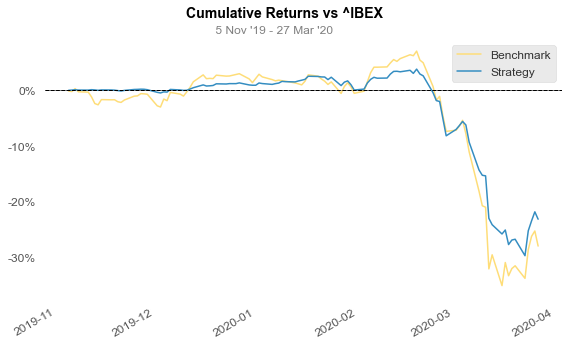

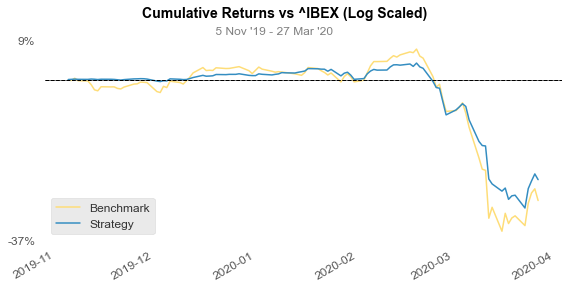

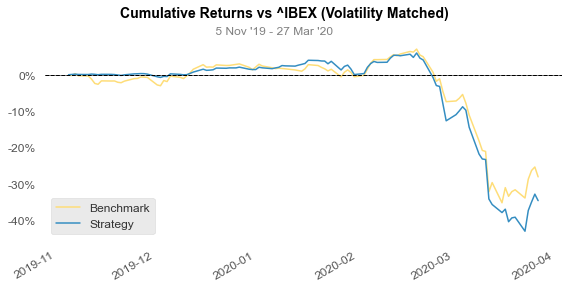

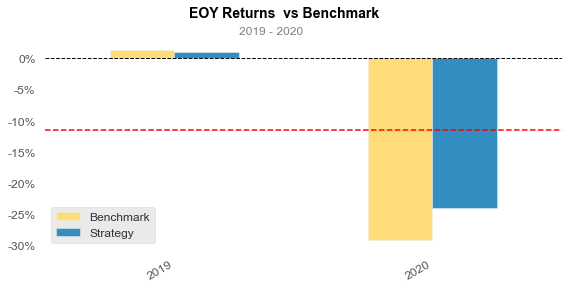

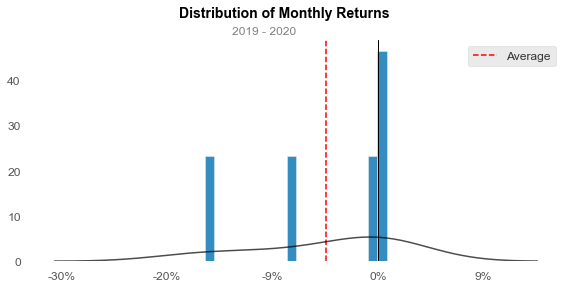

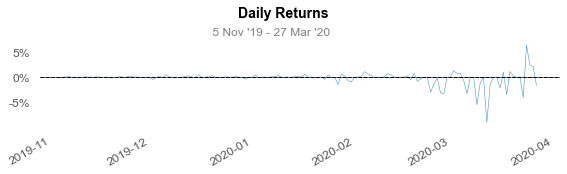

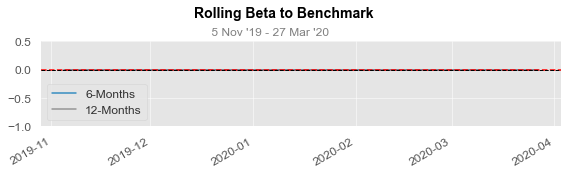

IndexError: index 0 is out of bounds for axis 0 with size 0

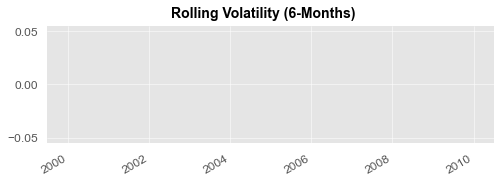

In [165]:
qs.reports.full(returns   = pf_returns_ss, 
           benchmark = '^IBEX')